In [1]:
# 添加库函数
import os
import torch
import torch.nn as nn
import math
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,OrthographicCameras
)
from pytorch3d.vis.plotly_vis import plot_batch_individually
from pytorch3d.ops.points_normals import estimate_pointcloud_normals
from pytorch3d.ops.mesh_face_areas_normals import mesh_face_areas_normals
from torch.autograd import gradcheck

def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(90, 90)
    ax.axis('equal')
    plt.show()

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:2")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [2]:
# 载入一个模型
trg_obj = 'Geographos Radar-based, low-res(1).obj'
# trg_obj = 'dolphin.obj'
# 读取卫星各项参数
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale 

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

# 为mesh添加材质信息
verts_rgb = torch.ones_like(trg_mesh.verts_packed())*255  # 使用纯白色作为默认颜色
verts_rgb = verts_rgb.unsqueeze(0)
textures = TexturesVertex(verts_features=verts_rgb)
trg_mesh.textures = textures

/home/hkz/.conda/envs/3d_env/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [3]:
print(trg_mesh.faces_packed().shape[0])

4092


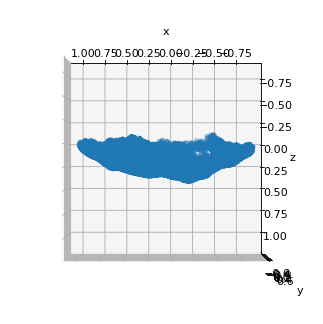

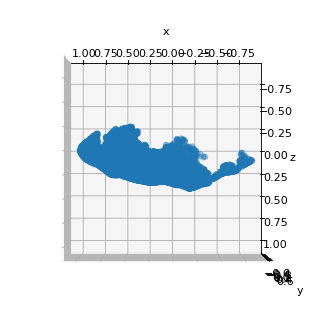

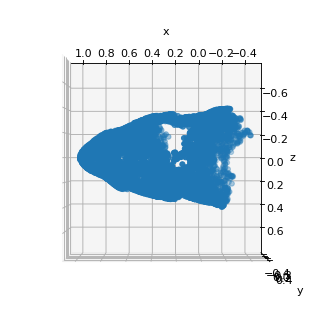

In [4]:
# 制造可视化模型
class visible_mesh(nn.Module):
    def __init__(self,device) -> None:
        super().__init__()
        self.device = device

    def forward(self,mesh,RadarLos_ele,RadarLos_azi):
        batch = RadarLos_ele.shape[0]
        face_num = mesh.faces_packed().shape[0]
        face_mask = torch.zeros((batch,face_num),dtype=bool,device=self.device)
        R, T = look_at_view_transform(dist=3,elev=RadarLos_ele, azim=RadarLos_azi)
        raster_settings = RasterizationSettings(
            image_size=1024, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
        )
        cameras = OrthographicCameras(device=self.device, R=R, T=T)
        rasterizer = MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        )
        fragments = rasterizer(mesh.extend(batch))
        # 在并行处理时，一个batch中的不同mesh有不同的面标识，但这些面标识有规律的从小到大排列,因此可以直接Unique
        p2f = fragments.pix_to_face
        p2f_mask = p2f[p2f>=0]
        p2f_mask_unique = torch.unique(p2f_mask)
        face_mask = face_mask.view(-1)
        face_mask[p2f_mask_unique] = True
        face_mask = face_mask.view(batch,-1)

        all_faces = mesh.faces_packed()
        all_verts = mesh.verts_packed() 
        # 利用面掩码生成批次索引
        batch_size, num_faces = face_mask.shape
        faces_batch = [all_faces[m] for m in face_mask]
        verts_batch = [all_verts] * batch_size  # 假设每个 batch 使用同样的顶点
        # 直接创建 Meshes 对象
        Meshes_new = Meshes(verts=verts_batch, faces=faces_batch)


        return Meshes_new

num_views = 20 
# 雷达视线角
radarele = torch.linspace(180, 180, num_views,device=device)
radarazi = torch.linspace(-180, 180, num_views,device=device)


visible_mesh1 = visible_mesh(device)
Meshes_new = visible_mesh1(trg_mesh,radarele,radarazi)


# faces = trg_mesh.faces_packed()[face_mask[6,:]]
# verts = trg_mesh.verts_packed()

# Meshes_new = Meshes(verts=[verts], faces=[faces])

plot_pointcloud(Meshes_new[1])
plot_pointcloud(Meshes_new[3])
plot_pointcloud(Meshes_new[5])

tensor([[-1.0000e+00,  0.0000e+00, -8.7423e-08],
        [-9.4582e-01, -2.9915e-16,  3.2470e-01],
        [-7.8914e-01, -7.3010e-16,  6.1421e-01],
        [-5.4695e-01,  6.1444e-17,  8.3717e-01],
        [-2.4549e-01, -2.9813e-16,  9.6940e-01],
        [ 8.2579e-02, -2.0126e-17,  9.9658e-01],
        [ 4.0170e-01, -9.5665e-16,  9.1577e-01],
        [ 6.7728e-01,  9.9995e-16,  7.3572e-01],
        [ 8.7947e-01,  5.3102e-16,  4.7595e-01],
        [ 9.8636e-01, -3.6349e-16,  1.6459e-01],
        [ 9.8636e-01,  3.6349e-16, -1.6459e-01],
        [ 8.7947e-01, -5.3102e-16, -4.7595e-01],
        [ 6.7728e-01, -9.9995e-16, -7.3572e-01],
        [ 4.0170e-01,  9.5665e-16, -9.1577e-01],
        [ 8.2579e-02,  2.0126e-17, -9.9658e-01],
        [-2.4549e-01,  2.9813e-16, -9.6940e-01],
        [-5.4695e-01, -6.1444e-17, -8.3717e-01],
        [-7.8914e-01,  7.3010e-16, -6.1421e-01],
        [-9.4582e-01,  2.9915e-16, -3.2470e-01],
        [-1.0000e+00,  0.0000e+00,  8.7423e-08]], device='cuda:2')
to

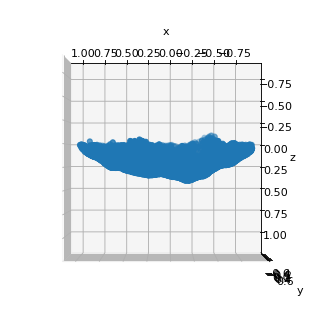

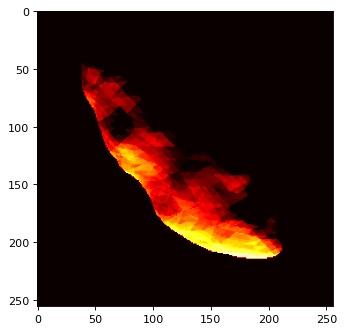

In [28]:
# 获得相机位置和视线位置对应的旋转矩阵

def get_normals(meshes):
    verts_packed = meshes.verts_packed()  # (V, 3)
    faces_packed = meshes.faces_packed()  # (F, 3)

    # 获取每个面的顶点
    faces_verts = verts_packed[faces_packed]  # (F, 3, 3)

    # 计算叉乘，获取法向量
    face_normals = torch.cross(
        faces_verts[:, 1] - faces_verts[:, 0],
        faces_verts[:, 2] - faces_verts[:, 0],
        dim=1
    )

    # 归一化法向量
    face_normals = face_normals / (face_normals.norm(dim=1, keepdim=True) + 1e-6)

    # face_normals 现在是每个面的法向量
    return face_normals

def rr2rd(meshes, doppler_vec, dopplercoefficient):
    verts_list = meshes.verts_list()
    faces_list = meshes.faces_list()

    # 确保 doppler_vec 的长度等于 verts_list 的长度
    if len(doppler_vec) != len(verts_list):
        raise ValueError("Length of doppler_vec must match number of vertex lists")

    projection_list = [
        (verts @ doppler_vec[i].unsqueeze(1)) * doppler_vec[i].unsqueeze(1).T
        for i, verts in enumerate(verts_list)
    ]
    
    scaled_projection = [proj * dopplercoefficient for proj in projection_list]
    scaled_verts_list = [verts + (scaled - proj) for verts, scaled, proj in zip(verts_list, scaled_projection, projection_list)]

    # 创建新的 Meshes 对象
    meshes_scaled = Meshes(verts=scaled_verts_list, faces=faces_list)

    return meshes_scaled

def angel2vec(ele,azi):
    elev_rad = torch.deg2rad(ele)
    azim_rad = torch.deg2rad(azi)
    
    direction_vector = torch.stack([
        torch.cos(elev_rad) * torch.sin(azim_rad),
        torch.sin(elev_rad),
        torch.cos(elev_rad) * torch.cos(azim_rad)
    ],dim=-1)

    return direction_vector

class mesh_radar_render(nn.Module):
    def __init__(self,device) -> None:
        super().__init__()
        self.device = device
    
    def forward(self,meshes,imageele,imageazi,radarlos,omega_vec,omega,dopplercoefficient):

        # 输入为 mesh [batch]
        # radarele [batch]
        # radarazi [batch]
        # omegaele [batch]
        # omegaazi [batch]
        # omega [batch]

        # from opts import config_parser
        # parser = config_parser()
        # args = parser.parse_args()

        # 多普勒轴
        doppler_vec = torch.cross(radarlos,omega_vec)
        print(doppler_vec)
        R,T = look_at_view_transform(dist=3,elev=imageele, azim=imageazi)
        cameras = OrthographicCameras(device=device, R=R, T=T)
        # 获得法向量
        normals = get_normals(meshes)
        print(normals.shape)
        # 对mesh进行变换到多普勒域
        meshes_scaled = rr2rd(meshes,doppler_vec,dopplercoefficient)
        plot_pointcloud(meshes_scaled[0])
        # 渲染
        raster_settings = RasterizationSettings(
            image_size=256, 
            blur_radius=0, 
            faces_per_pixel=3, 
        )
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        )
        fragments = rasterizer(meshes_scaled)

        zero_vector = torch.zeros(1, 3, device=self.device)
        normal_batch = torch.where(
            fragments.pix_to_face[...,None] == -1,                      # 添加维度适配零向量
            zero_vector,                               # 用零向量替换不合法的索引
            normals[fragments.pix_to_face.clamp_min(0)]                  # 使用 torch.clamp_min 防止负值索引
        )
        # normal_batch = normal_all[fragments_all.pix_to_face.clamp_min(0)]
        image = torch.sum(normal_batch*radar_vec.unsqueeze(1).unsqueeze(2).unsqueeze(3),dim=-1)
        image = torch.sum(image,dim = -1)

        return image

def vec_rot(vec,axis_x,axis_y,axis_z,theta):

    axis_x = axis_x.expand(theta.shape)
    axis_y = axis_y.expand(theta.shape)
    axis_z = axis_z.expand(theta.shape)

    c = torch.cos(theta)
    s = torch.sin(theta)
    one_c = 1 - c

    Rotmat = torch.stack([
        torch.stack([axis_x**2 * one_c + c, axis_x * axis_y * one_c - axis_z * s, axis_x * axis_z * one_c + axis_y * s], dim=-1),
        torch.stack([axis_x * axis_y * one_c + axis_z * s, axis_y**2 * one_c + c, axis_y * axis_z * one_c - axis_x * s], dim=-1),
        torch.stack([axis_x * axis_z * one_c - axis_y * s, axis_y * axis_z * one_c + axis_x * s, axis_z**2 * one_c + c], dim=-1)
    ], dim=-2)

    vec_rot = torch.matmul(Rotmat,vec.unsqueeze(1)).squeeze(2)

    return vec_rot

# batch = 37

# RadarLos = torch.tensor([-1.0,0,0], device=device)
# # RadarLos = torch.tensor([-1/2,0,-math.sqrt(3)/2], device=device)
# theta = torch.linspace(math.pi,0,batch).to(device)

# axis_x = torch.tensor([0.0], device=device)
# axis_y = torch.tensor([0.0], device=device)
# axis_z = torch.tensor([1.0], device=device)
# Round_radar_los = vec_rot(RadarLos,axis_x,axis_y,axis_z,theta)

# print(Round_radar_los)
# print(Round_radar_los.shape)
    
num_views = 20 
# 成像视线角
imageele = torch.linspace(90,90, num_views,device=device)
imageazi = torch.linspace(-180,180, num_views,device=device)
# 雷达视线向量
radar_vec = angel2vec(radarele,radarazi)
# 转轴
omageele = torch.linspace(90,90, num_views,device=device)
omageazi = torch.linspace(-180,180, num_views,device=device)
omage_vec = angel2vec(omageele,omageazi)
# 转速
omega = torch.tensor([1.0],device=device)
# 多普勒距离维系数
lambda1 = torch.tensor([2.0],device=device)
dopplercoefficient = 2*omega/lambda1

mesh_radar_render1 = mesh_radar_render(device)
image = mesh_radar_render1(Meshes_new,imageele,imageazi,radar_vec,omage_vec,omega,dopplercoefficient)     

plt.imshow(image[12,:,:].squeeze(0).detach().cpu(),cmap='hot')


In [12]:
test_verts = torch.tensor([[0.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0]], dtype=torch.float32)
test_faces = torch.tensor([[0, 1, 2]], dtype=torch.int64)

try:
    test_mesh = Meshes(verts=[test_verts], faces=[test_faces])
    print("Simple test mesh creation successful.")
except Exception as e:
    print("Error during simple test mesh creation:", e)

Simple test mesh creation successful.


pix_to_face shape: torch.Size([1, 256, 256, 2])
zbuf shape: torch.Size([1, 256, 256, 2])
bary_coords shape: torch.Size([1, 256, 256, 2, 3])
dists shape: torch.Size([1, 256, 256, 2])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:2')


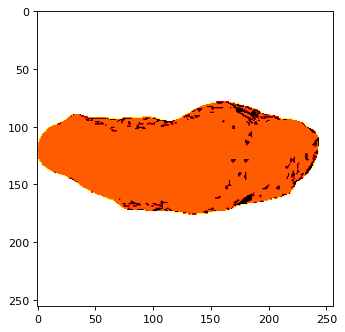

In [13]:
# 对模型进行光栅化
# the number of different viewpoints from which we want to render the mesh.


num_views = 20

# Get a batch of viewing angles. 
elev = torch.linspace(180, 180, num_views)
azim = torch.linspace(0, 0, num_views)

R, T = look_at_view_transform(dist=3, elev=elev, azim=azim)
cameras = OrthographicCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = OrthographicCameras(device=device, R=R[None, 0, ...], 
                                  T=torch.tensor([[0,0,10]])) 

raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=2, 
)

rasterizer=MeshRasterizer(
    cameras=camera, 
    raster_settings=raster_settings
)

fragments = rasterizer(trg_mesh)

print(f"pix_to_face shape: {fragments.pix_to_face.shape}")
print(f"zbuf shape: {fragments.zbuf.shape}")
print(f"bary_coords shape: {fragments.bary_coords.shape}")
print(f"dists shape: {fragments.dists.shape}")
p2f = fragments.pix_to_face
p2f = torch.clamp(p2f,min=0)
face_mask0 = face_mask[1,...].squeeze(0)
image = face_mask0[p2f]

image = torch.sum(image,dim = -1)
plt.figure()
plt.imshow(image.squeeze(0).detach().cpu(),cmap='hot')
print(image[0,100:150,100:150])

In [43]:
# 对模型进行光栅化
# the number of different viewpoints from which we want to render the mesh.


num_views = 20

# Get a batch of viewing angles. 
elev = torch.linspace(0, 0, num_views)
azim = torch.linspace(45, 45, num_views)

R, T = look_at_view_transform(dist=3, elev=elev, azim=azim)
cameras = OrthographicCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = OrthographicCameras(device=device, R=R[None, 0, ...], 
                                  T=torch.tensor([[0,0,10]])) 

raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=2, 
)

rasterizer=MeshRasterizer(
    cameras=camera, 
    raster_settings=raster_settings
)

fragments = rasterizer(trg_mesh)

print(f"pix_to_face shape: {fragments.pix_to_face.shape}")
print(f"zbuf shape: {fragments.zbuf.shape}")
print(f"bary_coords shape: {fragments.bary_coords.shape}")
print(f"dists shape: {fragments.dists.shape}")
p2f = fragments.pix_to_face

# pix2face_mask = torch.gather(face_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3).expand(-1, 256, 256, 2, -1), 4, p2f)

faces_verts = trg_mesh.verts_packed()[trg_mesh.faces_packed()]  # (num_faces, 3, 3)
normals = torch.cross(
    faces_verts[:, 1] - faces_verts[:, 0],
    faces_verts[:, 2] - faces_verts[:, 0],dim = -1
)
normals = normals / (normals.norm(dim=1, keepdim=True) + 1e-6)  # 归一化
p2f = fragments.pix_to_face
# face_normals = torch.zeros_like(p2f)
zero_vector = torch.zeros(1, 3, device=normals.device)
face_normals = torch.where(
    p2f[..., None] == -1,                      # 添加维度适配零向量
    zero_vector,                               # 用零向量替换不合法的索引
    normals[p2f.clamp_min(0)]                  # 使用 torch.clamp_min 防止负值索引
)
# face_normals = normals[fragments.pix_to_face]
print(f"dists shape: {face_normals.shape}")

pix_to_face shape: torch.Size([1, 256, 256, 2])
zbuf shape: torch.Size([1, 256, 256, 2])
bary_coords shape: torch.Size([1, 256, 256, 2, 3])
dists shape: torch.Size([1, 256, 256, 2])
dists shape: torch.Size([1, 256, 256, 2, 3])


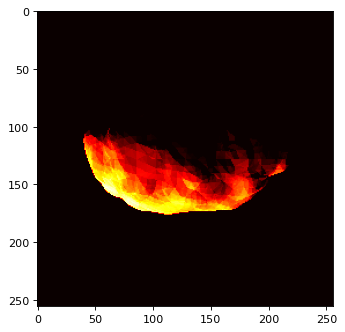

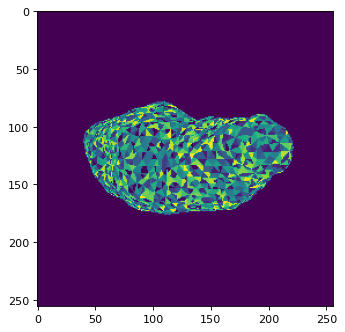

In [44]:
RadarLos = torch.tensor([-1.0,-1.0,0], device=device)
AMP = torch.matmul(face_normals,RadarLos)
image = torch.clamp(AMP,min = 0 )
image = torch.sum(image,dim = -1)

plt.figure()
plt.imshow(image.squeeze(0).detach().cpu(),cmap='hot')
plt.figure()
plt.imshow(fragments.pix_to_face[:,:,:,0].squeeze(0).detach().cpu())

In [6]:
mesh = trg_mesh

# 生成多个视角的相机参数
num_views = 5  # 假设我们有5个视角
R = torch.eye(3).unsqueeze(0).repeat(num_views, 1, 1)  # 重复旋转矩阵
T = torch.zeros(num_views, 3)  # 使用多个平移向量

# 创建相机对象
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# 定义光栅化设置
raster_settings = RasterizationSettings(
    image_size=128,
    blur_radius=0.0,
    faces_per_pixel=1
)

# 创建光栅器
rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)

# 批量光栅化多个视角
fragments = rasterizer(mesh.extend(num_views))

# 检查结果
print(fragments.pix_to_face.shape)  # (batch_size, image_size, image_size, faces_per_pixel)

torch.Size([5, 128, 128, 1])
